In [2]:
cd kddm/data/uas 

/glade/u/home/jkent/kddm/data/uas


In [3]:
ls

bilinear_129x300_257x599.nc
bilinear_49x116_97x231.nc
uas.METDATA.44i.nc@
uas.hist.CanESM2.CRCM5-UQAM.day.NAM-44i.kddm-METDATA.nc@
uas.hist.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.nc@
uas.rcp85.CanESM2.CRCM5-UQAM.day.NAM-44i.kddm-METDATA.nc@
uas.rcp85.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.nc@


In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy import interpolate
import xesmf as xe

In [5]:
%matplotlib inline

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [6]:
#Look at Data

In [7]:
uas_measured = xr.open_dataset('uas.METDATA.44i.nc')
uas_hist = xr.open_dataset('uas.hist.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.nc')
uas_rcp85 = xr.open_dataset('uas.rcp85.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.nc')

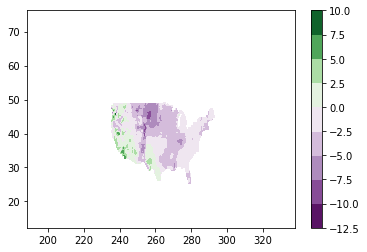

In [8]:
uas_measured_t0 = uas_measured.uas.isel(time=0)
plt.contourf(uas_measured.lon, uas_measured.lat, uas_measured_t0, norm=MidpointNormalize(midpoint=0.), cmap = 'PRGn')
plt.colorbar()

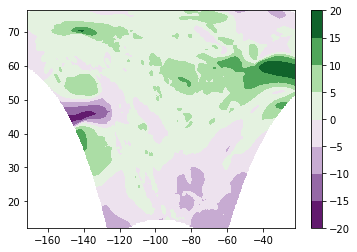

In [9]:
plt.contourf(uas_hist.lon, uas_hist.lat, uas_hist.uas.isel(time=0), norm=MidpointNormalize(midpoint=0.), cmap = 'PRGn')
plt.colorbar()

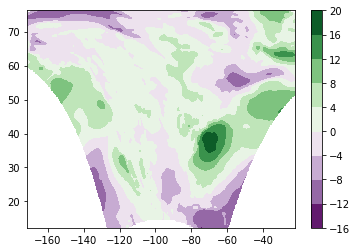

In [10]:
plt.contourf(uas_rcp85.lon, uas_rcp85.lat, uas_rcp85.uas.isel(time=0), norm=MidpointNormalize(midpoint=0.), cmap = 'PRGn')
plt.colorbar()

In [11]:
#Filter Data, Drop NaN dimensions
uas_measured_droppednan_lat = uas_measured.dropna(dim='lat',how='all')
uas_measured_droppednan = uas_measured_droppednan_lat.dropna(dim='lon',how='all')

In [12]:
#Regrid both model and measured to .25 degree lat lon grid

In [13]:
lon_min = float(np.min(uas_measured_droppednan.lon))
lon_max = float(np.max(uas_measured_droppednan.lon))
lat_min = float(np.min(uas_measured_droppednan.lat))
lat_max = float(np.max(uas_measured_droppednan.lat))
print(lon_min, lon_max, lat_min, lat_max)

235.25 292.75 25.25 49.25


In [14]:
#Add test that lon_min etc are products of 0.25
grid = 0.25
new_lon = np.arange(lon_min,lon_max+grid,grid)
new_lat = np.arange(lat_min,lat_max+grid,grid)

ds_newgrid = xr.Dataset({'lat': (['lat'], new_lat), 'lon': (['lon'], new_lon)})

In [15]:
#uas_measured_interpolated = uas_measured.interp(lon=new_lon, lat=new_lat)
#uas_measured_interpolated_t0 = uas_measured_interpolated.uas.isel(time=0)
#plt.contourf(uas_measured_interpolated.lon, uas_measured_interpolated.lat, uas_measured_interpolated_t0, norm=MidpointNormalize(midpoint=0.), cmap = 'PRGn')
#plt.colorbar()

In [16]:
regridder_measured = xe.Regridder(uas_measured_droppednan, ds_newgrid, 'bilinear')
uas_measured_regridded = regridder_measured(uas_measured_droppednan.uas)

Overwrite existing file: bilinear_49x116_97x231.nc 
 You can set reuse_weights=True to save computing time.


/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xesmf/smm.py:73: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


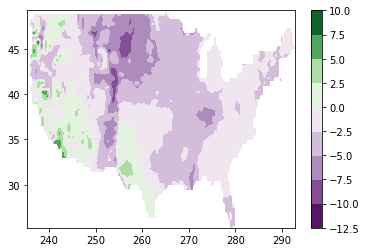

In [17]:
plt.contourf(uas_measured_regridded.lon, uas_measured_regridded.lat, uas_measured_regridded.isel(time=0), norm=MidpointNormalize(midpoint=0.), cmap = 'PRGn')
plt.colorbar()

In [18]:
uas_hist_poslon = uas_hist.assign_coords(lon= uas_hist.lon+ 360)
uas_hist_filtered = uas_hist_poslon.sel(lon=slice(lon_min, lon_max),lat=slice(lat_min, lat_max))
regridder_hist = xe.Regridder(uas_hist_filtered, ds_newgrid, 'bilinear')
uas_hist_regridded = regridder_hist(uas_hist_filtered.uas)

Overwrite existing file: bilinear_49x116_97x231.nc 
 You can set reuse_weights=True to save computing time.


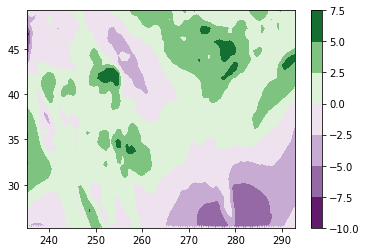

In [19]:
plt.contourf(uas_hist_regridded.lon, uas_hist_regridded.lat, uas_hist_regridded.isel(time=0), norm=MidpointNormalize(midpoint=0.), cmap = 'PRGn')
plt.colorbar()

In [20]:
uas_rcp85_poslon = uas_rcp85.assign_coords(lon= uas_hist.lon+ 360)
uas_rcp85_filtered = uas_rcp85_poslon.sel(lon=slice(lon_min, lon_max),lat=slice(lat_min, lat_max))
regridder_rcp85 = xe.Regridder(uas_rcp85_filtered, ds_newgrid, 'bilinear')
uas_rcp85_regridded = regridder_rcp85(uas_rcp85_filtered.uas)

Overwrite existing file: bilinear_49x116_97x231.nc 
 You can set reuse_weights=True to save computing time.


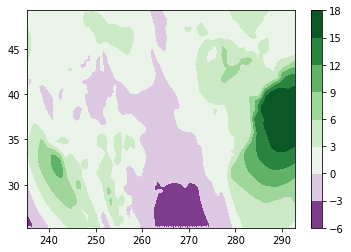

In [21]:
plt.contourf(uas_rcp85_regridded.lon, uas_rcp85_regridded.lat, uas_rcp85_regridded.isel(time=0), norm=MidpointNormalize(midpoint=0.), cmap = 'PRGn')
plt.colorbar()

In [22]:
#Put NaN's where there is always NaN in measured

In [23]:
#Alignepochs

In [25]:
time_measured = uas_measured_regridded.time
time_measured.encoding

{'source': '/glade/u/home/jkent/kddm/data/uas/uas.METDATA.44i.nc',
 'original_shape': (12784,),
 'dtype': dtype('float32'),
 'units': 'days since 1900-01-01 00:00:00',
 'calendar': 'gregorian'}

In [64]:
uas_hist_dropearlytime = uas_hist_regridded.sel(time=slice('1979-01',None))
time_hist = uas_hist_dropearlytime.time
time_hist.encoding

{'source': '/glade/u/home/jkent/kddm/data/uas/uas.hist.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.nc',
 'original_shape': (20440,),
 'dtype': dtype('float64'),
 'units': 'days since 1949-12-01 00:00:00',
 'calendar': '365_day'}

In [27]:
time_rcp85 = uas_rcp85_regridded.time
time_rcp85.encoding

{'source': '/glade/u/home/jkent/kddm/data/uas/uas.rcp85.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.nc',
 'original_shape': (34674,),
 'dtype': dtype('float64'),
 'units': 'days since 1949-12-01 00:00:00',
 'calendar': '365_day'}

In [30]:
calendar_measured = time_measured.encoding['calendar']
calendar_measured

'gregorian'

In [ ]:
#measured doesn't have a time bounds attribute, make one?
#What is the relationship between time_bnds and time units?
#Does the units have any meaning when in CFTime?
#Will come back to this when I understand the importance, 

In [45]:
hist_timebnds = uas_hist.time_bnds.sel(time=slice('1979-01',None))
hist_timebnds

<xarray.DataArray 'time_bnds' (time: 9855, bnds: 2)>
array([[10616., 10617.],
       [10617., 10618.],
       [10618., 10619.],
       ...,
       [20468., 20469.],
       [20469., 20470.],
       [20470., 20471.]])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T12:00:00 ... 2005-12-31T12:00:00
Dimensions without coordinates: bnds

In [47]:
rcp85_timebnds = uas_rcp85.time_bnds
rcp85_timebnds

<xarray.DataArray 'time_bnds' (time: 34674, bnds: 2)>
array([[20471., 20472.],
       [20472., 20473.],
       [20473., 20474.],
       ...,
       [55142., 55143.],
       [55143., 55144.],
       [55144., 55145.]])
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01T12:00:00 ... 2100-12-30T12:00:00
Dimensions without coordinates: bnds

In [48]:
#Moving window
moving_window_width = 30

In [52]:
#cslice fx from Seth
#try xr.rolling
uas_measured_rollmean = uas_measured_regridded.rolling(time=moving_window_width, min_periods=15, center=True).mean()
uas_measured_rollmean
#confirmed doesn't change time dimension

<xarray.DataArray (time: 12784, lat: 97, lon: 231)>
array([[[nan,  0., ...,  0., nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan,  0., ...,  0., nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan,  0., ...,  0., nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan,  0., ...,  0., nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * lon      (lon) float64 235.2 235.5 235.8 236.0 ... 292.0 292.2 292.5 292.8
  * lat      (lat) float64 25.25 25.5 25.75 26.0 26.25 ... 48.5 48.75 49.0 49.25
  * time     (time) datetime64[ns] 1979-01-01T18:00:00 ... 2013-12-31T18:00:00

In [53]:
uas_hist_rollmean = uas_hist_regridded.rolling(time=moving_window_width, min_periods=15, center=True).mean()
uas_hist_rollmean

<xarray.DataArray (time: 20440, lat: 97, lon: 231)>
array([[[-3.336259,  0.      , ...,  0.      , -0.894629],
        [-3.209074, -3.083433, ..., -1.117965, -0.973163],
        ...,
        [-0.189261, -0.172321, ...,  1.862979,  1.842994],
        [-0.212879, -0.249934, ...,  2.254913,  2.414619]],

       [[-3.506194,  0.      , ...,  0.      , -0.873462],
        [-3.380746, -3.257432, ..., -1.110368, -0.953504],
        ...,
        [-0.295881, -0.270177, ...,  1.810476,  1.792982],
        [-0.283379, -0.32241 , ...,  2.222575,  2.388772]],

       ...,

       [[-4.462241,  0.      , ...,  0.      ,  0.119583],
        [-4.37459 , -4.32635 , ...,  0.303702,  0.344343],
        ...,
        [-0.557238, -0.596459, ...,  1.396017,  1.340397],
        [-0.587538, -0.763485, ...,  1.367409,  1.389134]],

       [[-4.396983,  0.      , ...,  0.      ,  0.042231],
        [-4.314331, -4.270004, ...,  0.209798,  0.243694],
        ...,
        [-0.663023, -0.685925, ...,  1.163828,  1.1

In [69]:
#Seth doesn't drop any data but would have two models split (matching measured, future)
uas_rcp85_droplatetime = uas_rcp85_regridded.sel(time=slice(None,'2013-12-31'))
uas_rcp85_future = uas_rcp85_regridded.sel(time=slice('2014-01-01',None))

In [70]:
uas_past_model = xr.concat((uas_hist_dropearlytime, uas_rcp85_droplatetime), dim='time')

In [82]:
uas_past_model.time

<xarray.DataArray 'time' (time: 12775)>
array(['1979-01-01T12:00:00.000000000', '1979-01-02T12:00:00.000000000',
       '1979-01-03T12:00:00.000000000', ..., '2013-12-29T12:00:00.000000000',
       '2013-12-30T12:00:00.000000000', '2013-12-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T12:00:00 ... 2013-12-31T12:00:00
Attributes:
    coordinate_defines:  point
    bounds:              time_bnds
    delta_t:             0000-00-01 00:00:00
    axis:                T
    standard_name:       time
    long_name:           time

In [110]:
import pandas as pd
from calendar import isleap

#Code to determine if year in measured data is leap year
years = uas_measured_regridded.time.dt.year
leap_bool = [isleap(y.values) for y in years]
#Would it be terrible to interpolate years with 366 days to a year of 355 days? then I can just use xarray rolling
#or interpolate every 4 year cycle to be 4*365 =1460 instead of 4*365+1 = 1461
#or just interpolate February to alwasy be 28 days, I like the 4 year cycle the best

In [138]:
uas_measured_first4yrs = uas_measured_regridded.isel(time=slice(None,1461))
uas_measured_first4yrs.time

<xarray.DataArray 'time' (time: 1461)>
array(['1979-01-01T18:00:00.000000000', '1979-01-02T18:00:00.000000000',
       '1979-01-03T18:00:00.000000000', ..., '1982-12-29T00:00:00.000000000',
       '1982-12-30T00:00:00.000000000', '1982-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T18:00:00 ... 1982-12-31
Attributes:
    axis:           T
    standard_name:  time
    long_name:      time

In [126]:
a = (uas_measured_first4yrs.time.dt.day.values)
#Checking to see if different hours 0 and 18 means there is a repeat day?
for i in a:
    if (a[i]==a[i+1]):
        print(i)

In [133]:
set(uas_measured_regridded.time.dt.hour.values)

{0, 18}

In [139]:
uas_past_model_first4yrs = uas_past_model.isel(time=slice(None,1460))
uas_past_model_first4yrs.time

<xarray.DataArray 'time' (time: 1460)>
array(['1979-01-01T12:00:00.000000000', '1979-01-02T12:00:00.000000000',
       '1979-01-03T12:00:00.000000000', ..., '1982-12-29T12:00:00.000000000',
       '1982-12-30T12:00:00.000000000', '1982-12-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T12:00:00 ... 1982-12-31T12:00:00
Attributes:
    coordinate_defines:  point
    bounds:              time_bnds
    delta_t:             0000-00-01 00:00:00
    axis:                T
    standard_name:       time
    long_name:           time

In [132]:
set(uas_past_model.time.dt.hour.values)

{12}

In [ ]:
uas_measured_first1yrs = uas_measured_regridded.isel(time=slice(None,356))
uas_measured_first1yrs.time